# Обработка результатов к работе 3.5.1

### Удовин Илья, 874

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
%matplotlib notebook
from lab import *
f = lambda x, a, b: a*x + b
g = lambda x, a, b, c: a * np.tanh(b * x) + c * x
h = lambda x, p: np.dot([x**i for i in range(len(p)-1,-1,-1)], p)

data = {}
objects = os.listdir('.')
for name in objects:
    if name.endswith('.csv'):
        data[name[:-4]] = pd.read_csv(name, sep=',', header=None)

print('Data is ready!')
_display_normal = True

Data is ready!


## Вольт-амперная характеристика разряда

<IPython.core.display.Javascript object>


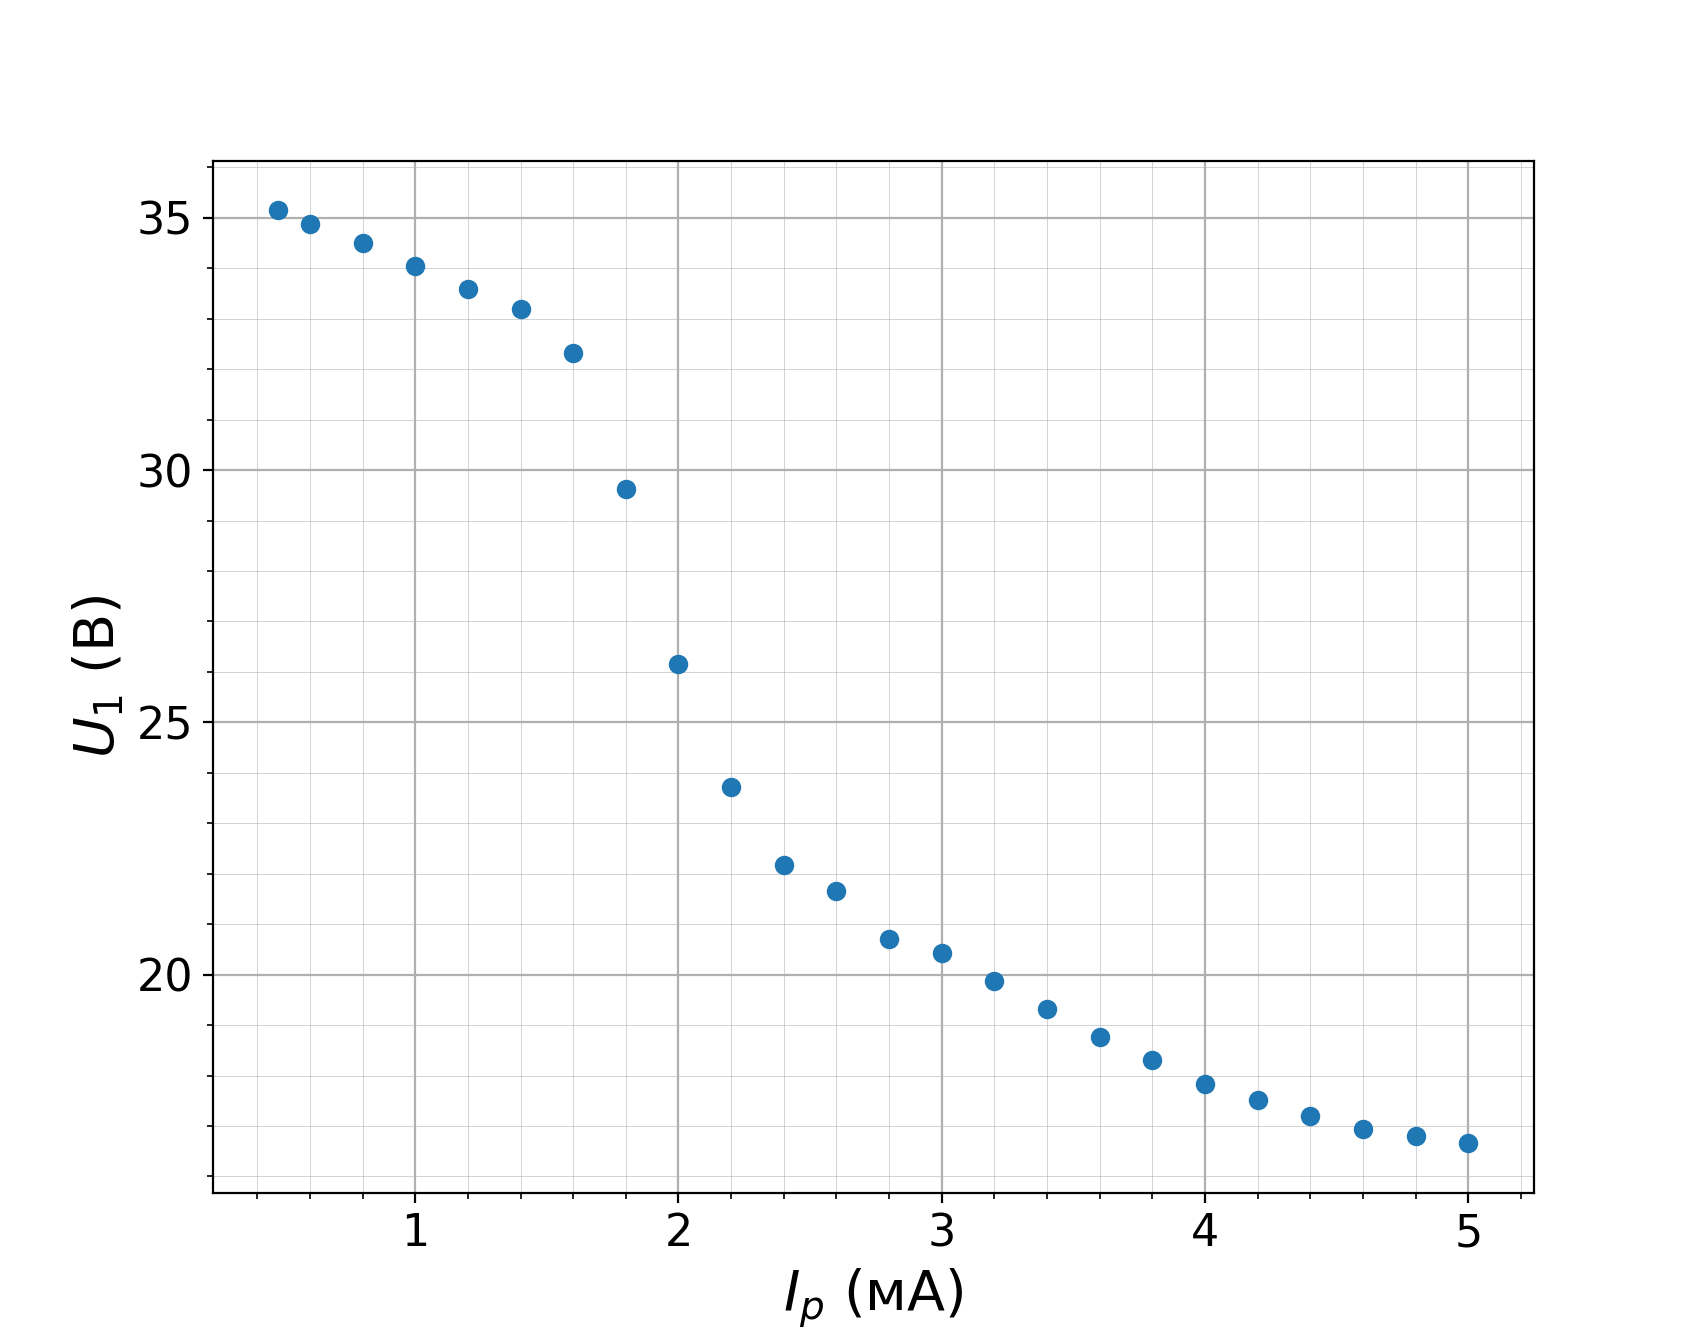

,"$I_р$, мА","$U$, В"
0,0.48,35.15
1,0.80,34.50
2,1.00,34.05
3,1.20,33.58
4,1.40,33.20


<IPython.core.display.Math object>

In [2]:
p = np.array(data['IU1'])
I_d = p[0] * 0.04 
U_1 = p[1]

sigma_I = 0.02
sigma_U = 0.05

if _display_normal:
    create_plot('', r'$I_р$ (мА)', r'$U_1$ (В)', 'L', 2)
    plt.yticks(np.arange(15, 36, 5))
    plt.errorbar(I_d, U_1, linestyle='', marker='o', xerr=sigma_I, yerr=sigma_U)
else:
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    p = plt.subplot(grid[0, 1])
    p.set_xlabel('$I_p$ (мА)', fontsize=15)
    p.set_ylabel('$U_1$ (В)', fontsize=15)
    p.errorbar(I_d, U_1, linestyle='', marker='.', xerr=sigma_I, yerr=sigma_U)

R = [(U_1[k] - U_1[k-1]) / (I_d[k] - I_d[k-1]) for k in range(1, len(U_1))]
R = np.abs(R)

df = np.transpose(np.array([I_d, U_1]))
df = pd.DataFrame(df, columns=['$I_р$, мА', '$U$, В'])
display(df.head())
display(Math('$R_{{max}}={:.2f}$'.format(max(R))))

## Зондовые характеристики

<IPython.core.display.Javascript object>


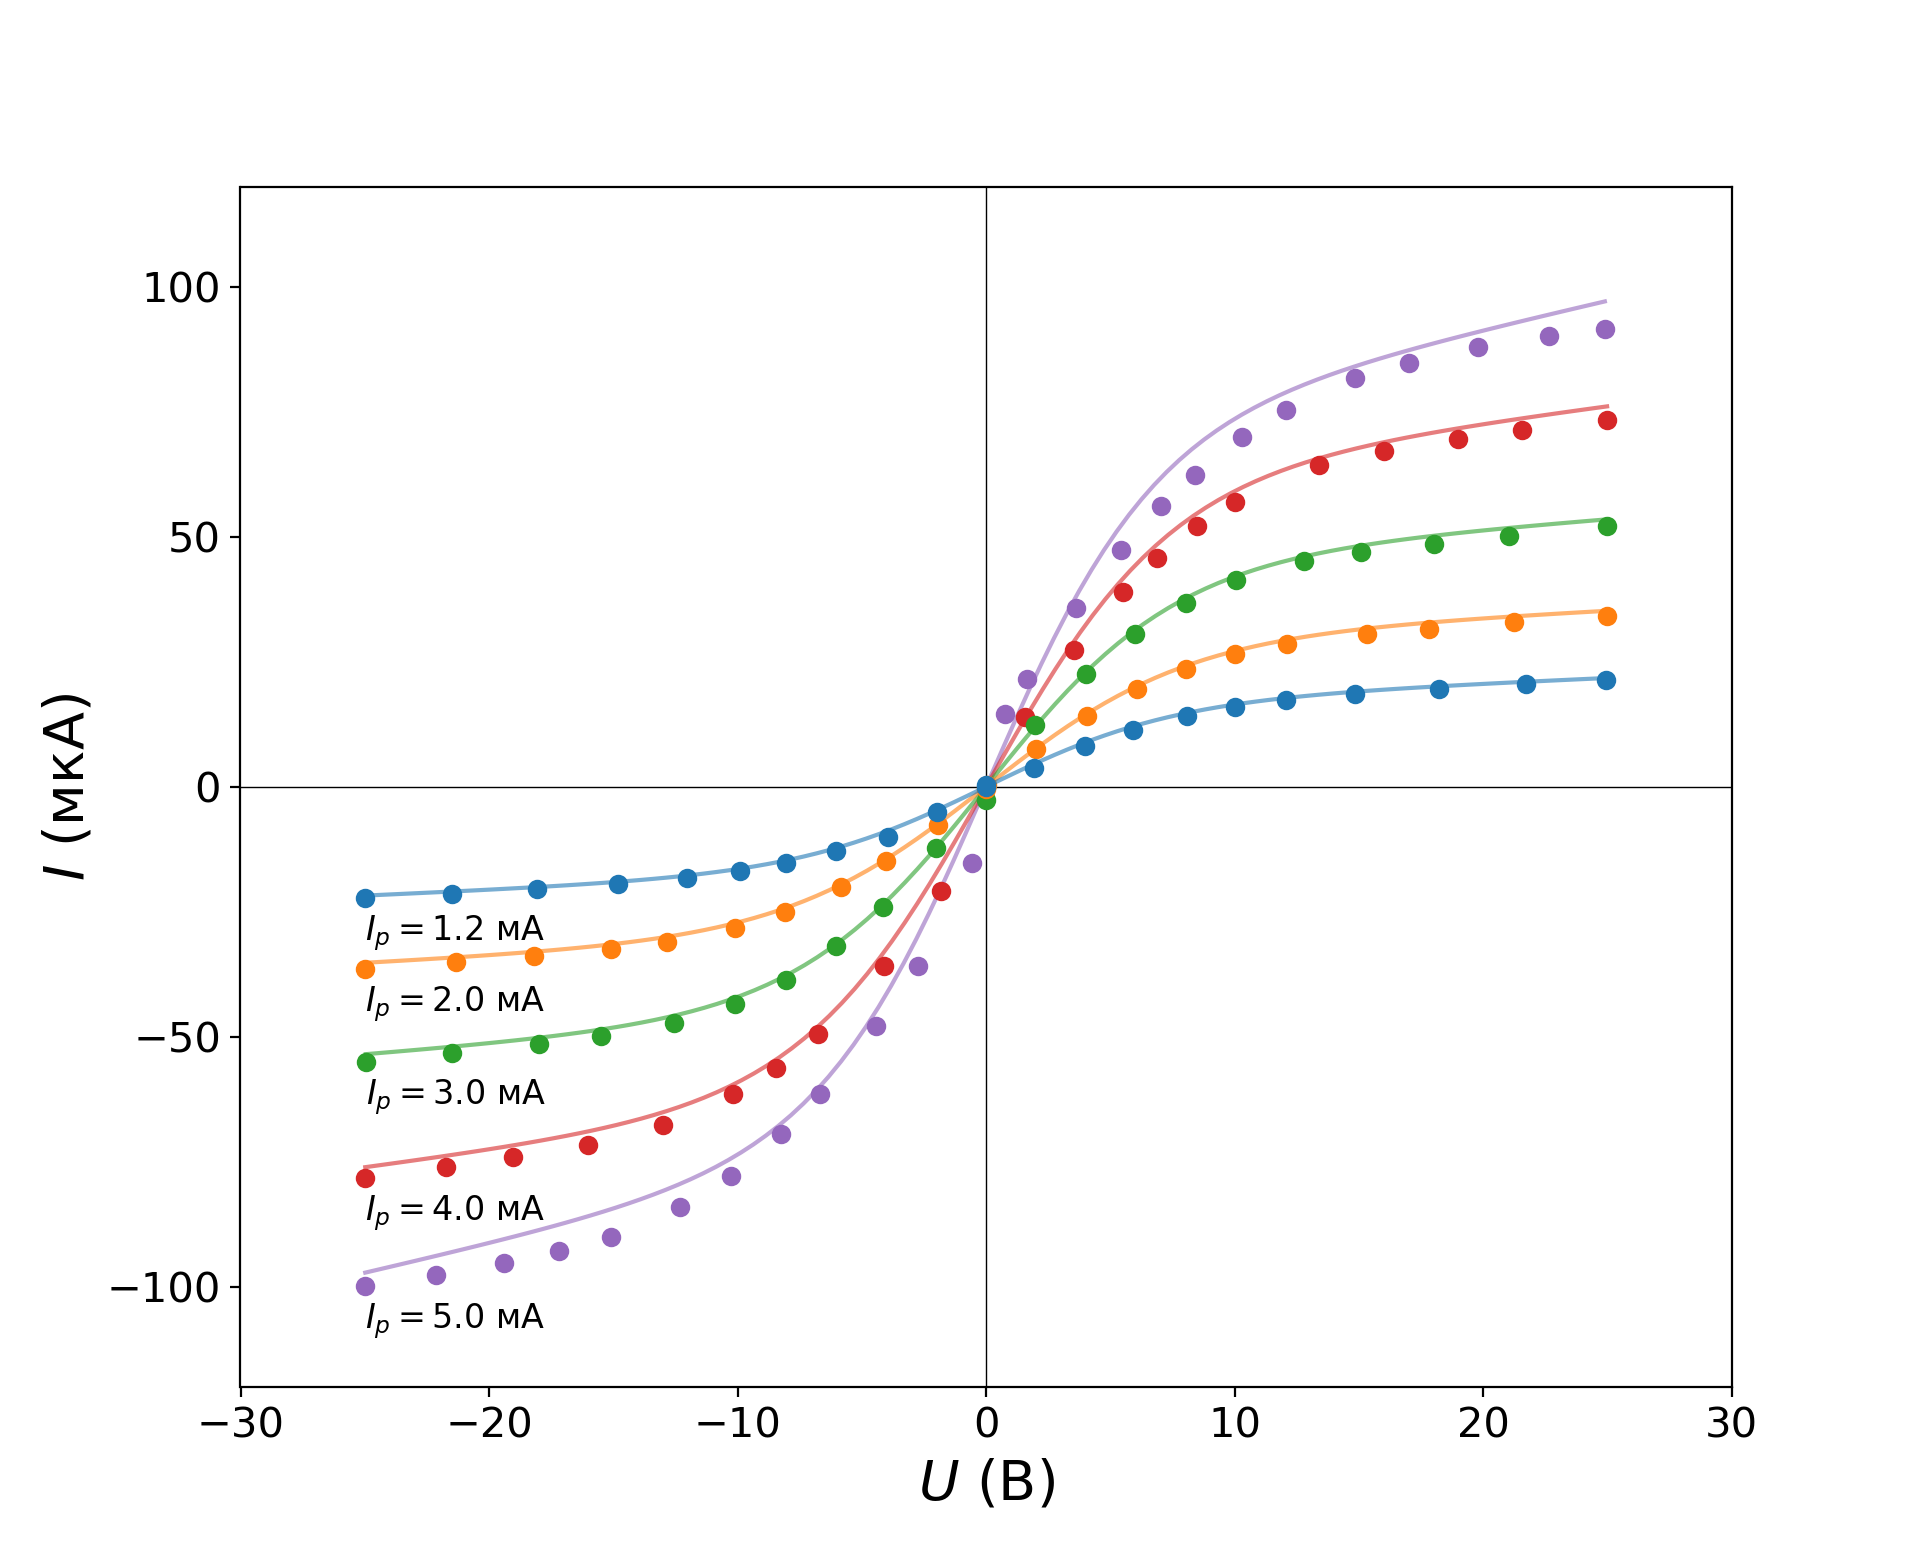

In [3]:
I_d = np.array([1.2, 2, 3, 4, 5])
k = [11, 11, 10, 10, 13]

OPTs = []
COVs = []

deltaU = []


plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('$U$ (В)', fontsize=20)
plt.ylabel('$I$ (мкА)', fontsize=20)

plt.plot([0, 0], [-150, 150], linewidth=0.5, color='0')
plt.plot([-40, 50], [0, 0], linewidth=0.5, color='0')
plt.xlim(-30, 30)
plt.ylim(-120, 120)

for i in range(len(I_d)-1, -1, -1):
    p = np.array(data['z'+str(i+1)])
    if i % 2 == 0:
        I = np.append(p[0][:k[i]], -p[0][k[i]:])
        U = np.append(p[1][:k[i]], -p[1][k[i]:])
    else:
        if i == 3:
            I = np.append(-p[0][:10], p[0][11:-1])
            U = np.append(-p[1][:10], p[1][11:-1])
        else:
            I = np.append(-p[0][:k[i]], p[0][k[i]:])
            U = np.append(-p[1][:k[i]], p[1][k[i]:])
    U = np.sort(U)
    I = np.sort(I)
    
    if i == 4:
        opt1, cov1 = curve_fit(g, U, I)
        opt, cov = opt1, cov1
    else:
        opt, cov = curve_fit(g, U, I, opt1)
    OPTs.append(opt)
    COVs.append(cov)
    g_true = lambda x: g(x, *opt)
    
    #g_delta = lambda x: g_true(x) - opt[0]
    #dU = fsolve(g_delta, opt[0])[0]
    dU = opt[0] / derivative(g_true, 0)
    deltaU.append(dU)
    
    # Uncomment to check
    #plt.plot([-30, 30], [opt[0], opt[0]], linewidth=0.5, color='C'+str(i))
    #plt.plot([dU, dU], [-150, 150], linewidth=0.5, color='C'+str(i))
    #plt.plot([0, dU], [0, opt[0]], linewidth=0.5, color='C'+str(i))
    
    x = np.linspace(min(U), max(U), 100)
    plt.plot(x, g_true(x), color='C'+str(i), alpha=0.6)
    lbl = '$I_{{р}}={:.1f}$ мА'.format(I_d[i])
    plt.plot(U, I, linestyle='', marker='o', color='C'+str(i), label=lbl)
    txt = '$I_{iн}'+'= {:.2f}$ мкА\n $e/(2kT_e)={:.3f}$'.format(*opt[:2]) 
    plt.text(min(U), min(I)-3, lbl, verticalalignment='top', fontsize=12)

$$I = I_{iн}\text{th}\frac{eU}{2kT_e}+AU$$

## Погрешности параметров зондовых характеристик

In [4]:
df = []
for i in range(len(OPTs)):
    i_d = I_d[i]
    opt = OPTs[i]
    cov = COVs[i]
    row = [i_d, *opt, math.sqrt(cov[0,0]), math.sqrt(cov[1,1]), math.sqrt(cov[2,2])]
    df.append(row)
display(pd.DataFrame(df, 
        columns=['$I_p$, мА', '$I_{iн}$, мкА', r'$\frac{e}{2kT_e}$', '$A$, В$^{-1}$', 
                 '$\sigma_{I_{iн}}$, мкА', '$\sigma_{e(2kT_e)^{-1}}$', '$\sigma_A$, В$^{-1}$']))

deltaU = np.array(deltaU) 
# display(pd.DataFrame(np.transpose([I_d, deltaU]), columns=['$I_p$, мА', '$\Delta U$, В']))

,"$I_p$, мА","$I_{iн}$, мкА",$\frac{e}{2kT_e}$,"$A$, В$^{-1}$","$\sigma_{I_{iн}}$, мкА",$\sigma_{e(2kT_e)^{-1}}$,"$\sigma_A$, В$^{-1}$"
0,1.2,68.817830,0.149247,1.139192,8.330708,0.021640,0.406664
1,2.0,60.226011,0.135559,0.640908,5.906122,0.014433,0.277013
2,3.0,44.110884,0.131933,0.380715,2.972154,0.009398,0.139255
3,4.0,29.013514,0.125139,0.252301,2.269568,0.009854,0.103986
4,5.0,16.440455,0.133422,0.214743,1.387933,0.012141,0.064837


## Температура и концентрация

$$n_e = \frac{I_{iн}}{0,4eS}\sqrt{\frac{m_i}{2kT_e}}\hspace{10pt} [СИ]$$

<IPython.core.display.Javascript object>


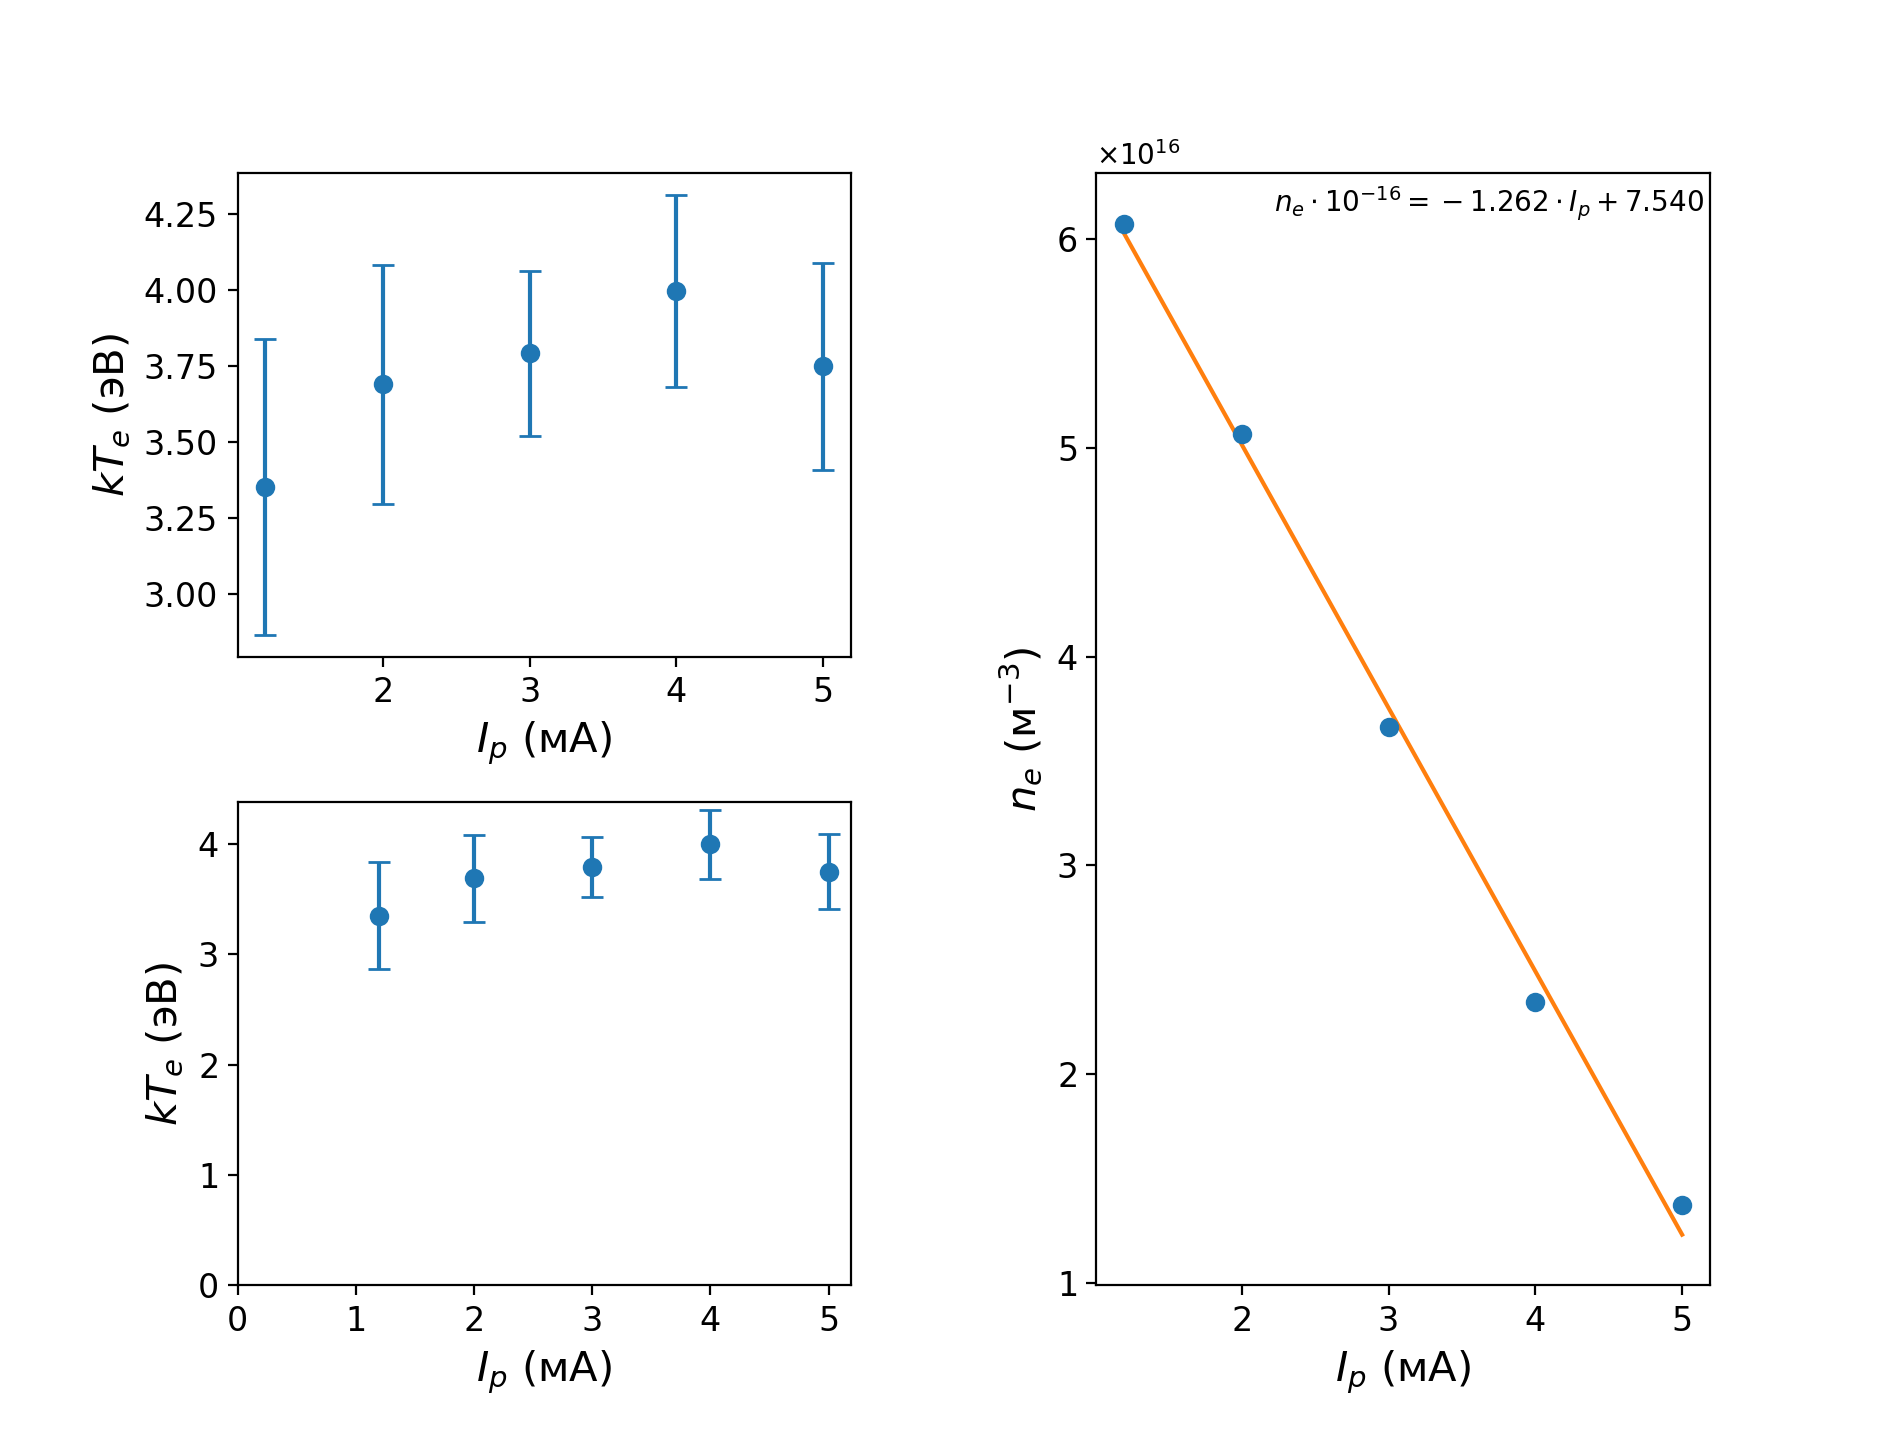

,"$I_р$, мА","$kT_e$, эВ","$n_e$, м$^{-3}$","$\sigma_{kT}$, эВ","$\sigma_n$, м$^{-3}$"
0,1.2,3.350144,6.074303e+16,0.485744,4.403627e+15
1,2.0,3.688440,5.066289e+16,0.392702,2.696998e+15
2,3.0,3.789788,3.660711e+16,0.269961,1.303834e+15
3,4.0,3.995553,2.344980e+16,0.314628,9.232723e+14
4,5.0,3.747509,1.372049e+16,0.341025,6.242862e+14


In [5]:
# температура

e = 1
I_0 = np.array([opt[0] for opt in OPTs])
e_2kT = np.array([opt[1] for opt in OPTs])

kT = e / (2*e_2kT)

eps_kT = np.array([math.sqrt(COVs[i][1, 1]) / OPTs[i][1] for i in range(len(OPTs))])
sigma_kT = eps_kT * kT


grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
axes = [plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0])]

for p in axes:
    p.set_xlabel('$I_p$ (мА)', fontsize=15)
    p.set_ylabel('$kT_e$ (эВ)', fontsize=15)
    p.tick_params(axis='both', which='major', labelsize=12)
    p.errorbar(I_d, kT, linestyle='', marker='o', yerr=sigma_kT, capsize=4)
    opt, cov = curve_fit(f, I_d, kT)
    #p.plot(I_d, f(I_d, *opt))
    #txt = '$kT={:.3f}\cdot I_р+{:.3f}$'.format(*opt)
    
plt1, plt2 = axes
xx, yy = plt1.get_xlim(), plt1.get_ylim()
#plt1.text(xx[0] + (xx[1] - xx[0]) * 1e-2 , yy[1] - (yy[1] - yy[0]) * 1e-2, txt, 
#           verticalalignment='top', horizontalalignment='left', fontsize=10)

plt2.set_xlim(0, xx[1])
plt2.set_ylim(0, yy[1])
plt2.ticklabel_format(axis='y', style='sci', scilimits=(1, 10), useMathText=True)
xx, yy = plt2.get_xlim(), plt2.get_ylim()
#plt2.text(xx[1] - (xx[1] - xx[0]) * 1e-2 , yy[0] + (yy[1] - yy[0]) * 1e-2, txt, 
#           verticalalignment='bottom', horizontalalignment='right', fontsize=10)


# концентрация

m_i = 22 * 1.66e-27  # кг
S = math.pi * 0.2 * 5.2 * 1e-6  # м^2
e = 1.6e-19  # Кл

n_e = I_0*1e-6 / (0.4*e*S) * np.sqrt(m_i/(2*kT*e))  # СИ

eps_n = eps_kT / 2
sigma_n = eps_n * n_e

plt3 = plt.subplot(grid[0:, 1])
plt3.set_xlabel('$I_p$ (мА)', fontsize=15)
plt3.set_ylabel('$n_e$ (м$^{-3}$)', fontsize=15)
plt3.tick_params(axis='both', which='major', labelsize=12)
plt3.ticklabel_format(axis='y', style='sci', useMathText=True)

plt3.plot(I_d, n_e, linestyle='', marker='o')

p = np.polyfit(I_d, n_e, 1)
plt3.plot(I_d, [np.dot([i, 1], p) for i in I_d], zorder=0)
txt = '$n_e\cdot 10^{{-16}}={:.3f}\cdot I_р+{:.3f}$'.format(*p*1e-16)
xx = plt3.get_xlim()
yy = plt3.get_ylim()
plt3.text(xx[1] - (xx[1] - xx[0]) * 1e-2 , yy[1] - (yy[1] - yy[0]) * 1e-2, txt, 
           verticalalignment='top', horizontalalignment='right', fontsize=10)


df = np.transpose(np.array([I_d, kT, n_e, sigma_kT, sigma_n]))
df = pd.DataFrame(df, columns=['$I_р$, мА', '$kT_e$, эВ', '$n_e$, м$^{-3}$', 
                               '$\sigma_{kT}$, эВ', '$\sigma_n$, м$^{-3}$'])
display(df)


#print(deltaU/kT)

n = n_e  # * np.exp(deltaU/kT)
n_i = n  # * np.exp(deltaU/kT)

df = np.transpose([I_d, n, n_i])
df = pd.DataFrame(df, columns=['$I_р$, мА', '$n$, м$^{-3}$', '$n_i$, м$^{-3}$'])
#display(df)

<!--$$n_e = n\cdot \exp\left(-\frac{e\Delta U}{kT}\right)$$

$$n_i = n\cdot \exp\left(\frac{e\Delta U}{kT}\right)$$-->


## Частота колебаний, дебаевский радиус

$$\omega_p = \sqrt\frac{n_e e^2}{\varepsilon_0 m_e}$$

$$r_D = \sqrt\frac{\varepsilon_0 kT}{ne^2}\ \text{[СИ]} = \sqrt{\frac{kT}{4\pi n e^2}}\ \text{[СГС]}$$

Если считать все в СИ, то есть готовая формула
$$r_D\ /\ [\text{м}] = 69\sqrt\frac{T\ /\ [\text{К}]}{n\ /\ [\text{м}^{-3}]}$$

<IPython.core.display.Javascript object>


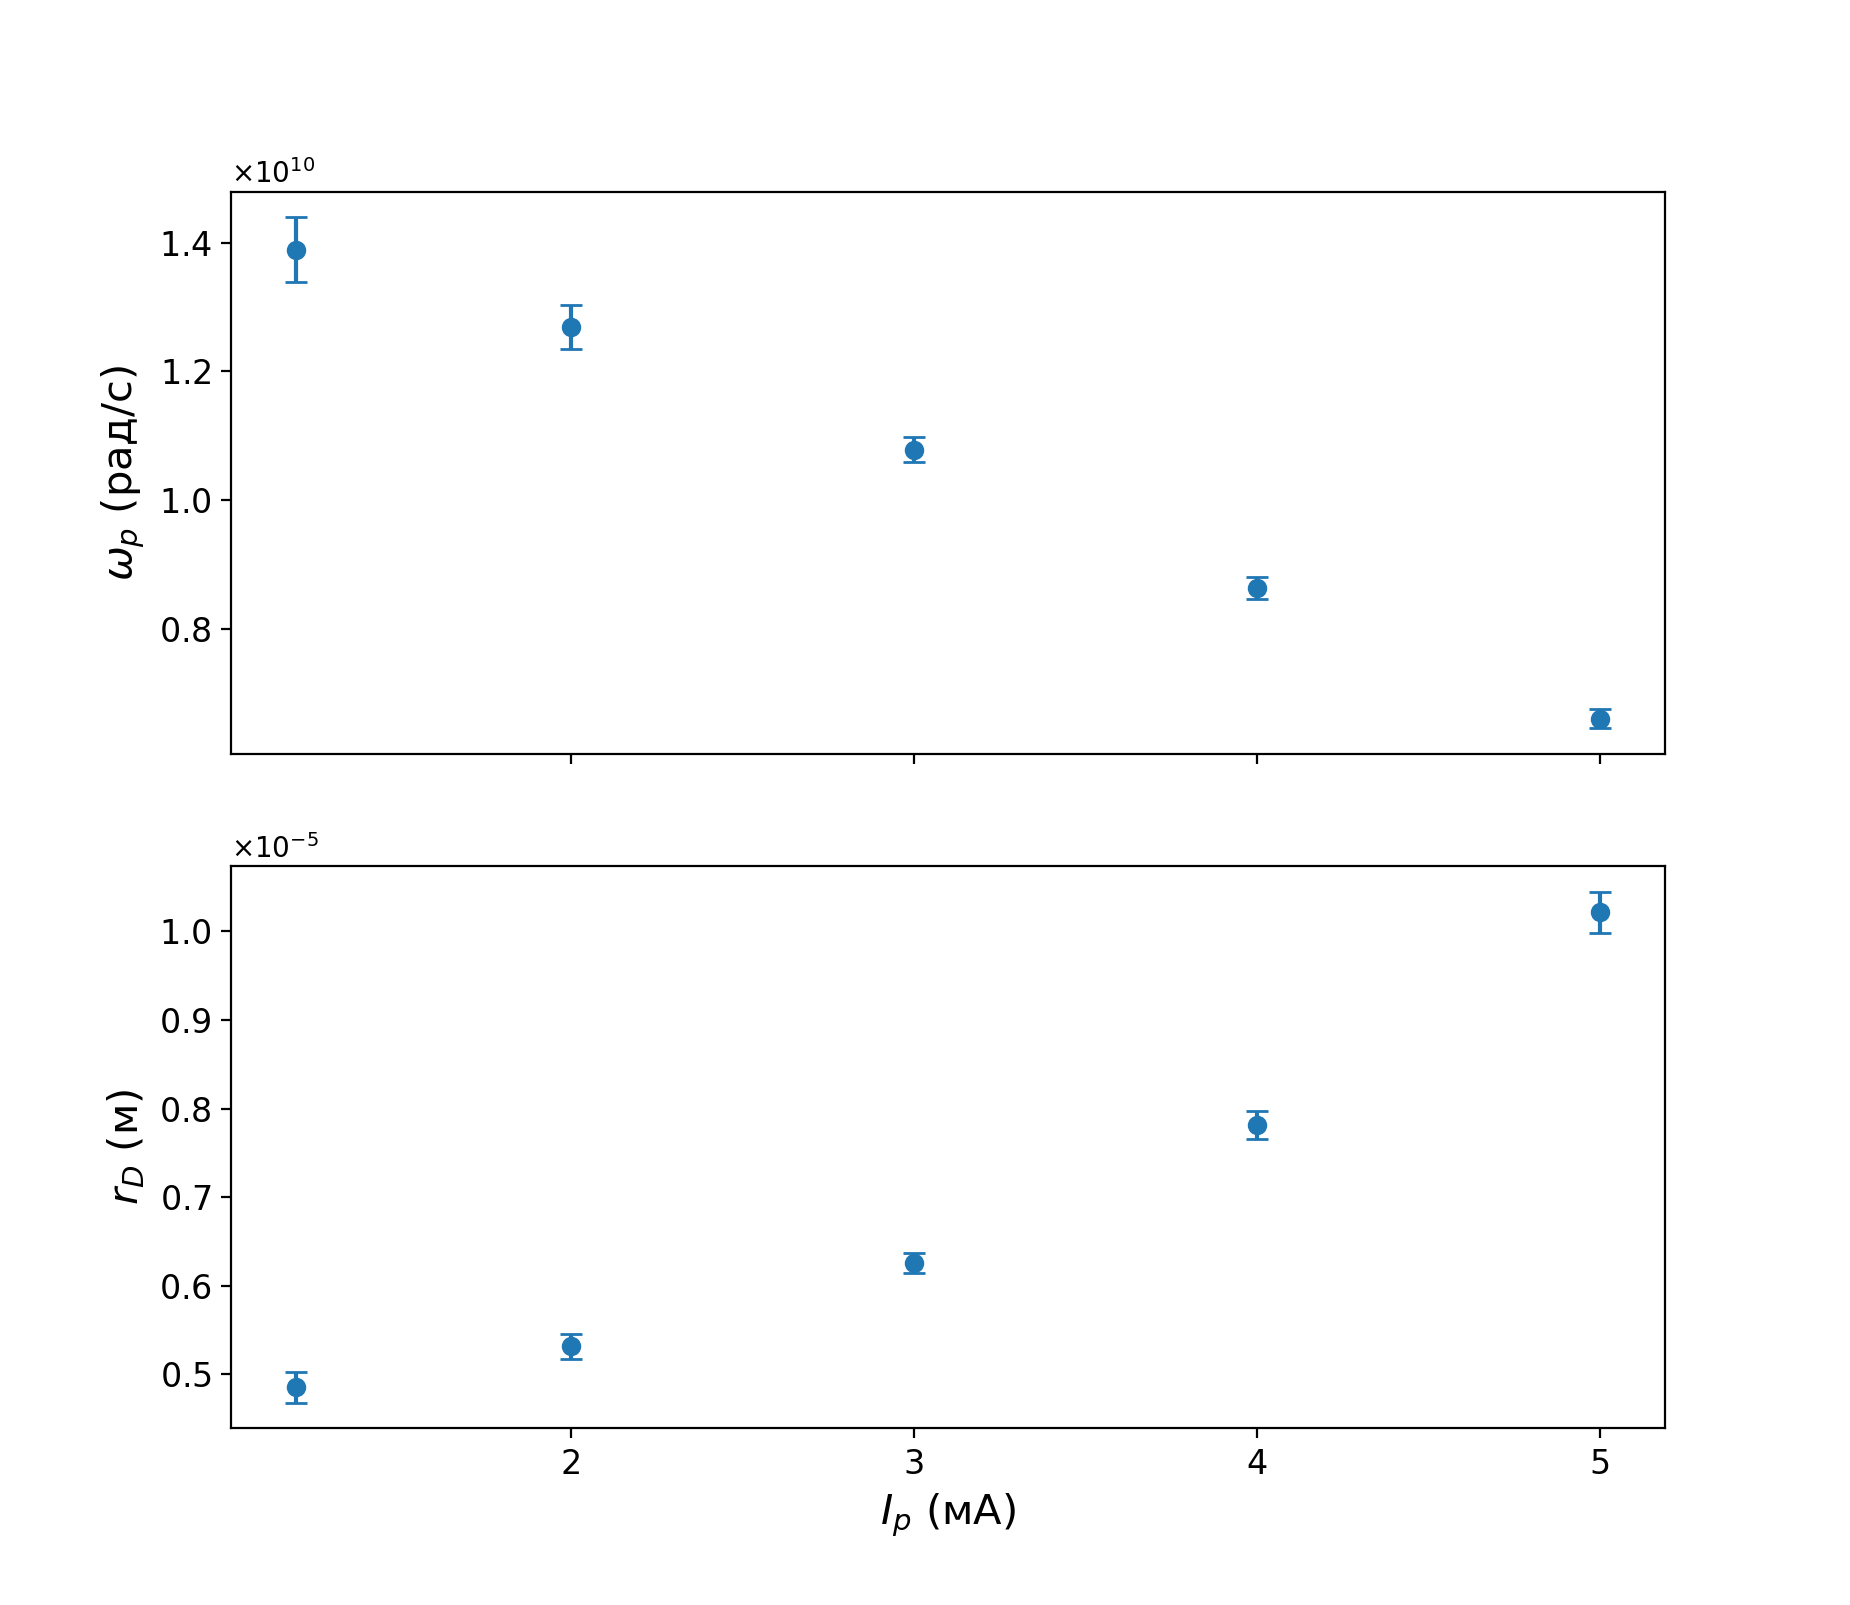

,"$I_р$, мА","$\omega_p$, рад/с","$r_D$, м","$\sigma_{\omega_p}$, рад/с","$\sigma_{r_D}$, м"
0,1.2,1.389242e+10,0.000005,5.035723e+08,1.759891e-07
1,2.0,1.268745e+10,0.000005,3.377032e+08,1.415030e-07
2,3.0,1.078480e+10,0.000006,1.920609e+08,1.113766e-07
3,4.0,8.631754e+09,0.000008,1.699260e+08,1.538300e-07
4,5.0,6.602591e+09,0.000010,1.502099e+08,2.324070e-07


,"$r_D$, $10^{-6}$ м (по-честному)","$r_D$, $10^{-6}$ м (готовая формула)"
0,4.849104,4.855139
1,5.309636,5.316245
2,6.246359,6.254134
3,7.804412,7.814126
4,10.202929,10.215629


In [6]:
if _display_normal:
    fig, axes = plt.subplots(2, 1, sharex='col', sharey='row')
else:
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    axes = [plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0])]

for p in axes:
    p.set_xticks(range(1, 6))
    p.tick_params(axis='both', which='major', labelsize=12)
    p.tick_params(axis='both', which='major', labelsize=12)


plt1, plt2 = axes

plt1.ticklabel_format(axis='y', style='sci', useMathText=True)
plt2.ticklabel_format(axis='y', style='sci', scilimits=(1, 10), useMathText=True)


# Далее все считаем в СИ

eps_0 = 8.854e-12  # Ф/м
m_e = 9.1e-31  # кг 
T_i = 300  # К
k = 1.38e-23  # Дж/К


# частота

omega = np.sqrt(n_e*e**2 / (eps_0*m_e))  

eps_omega = eps_n / 2
sigma_omega = eps_omega * omega

plt1.set_ylabel('$\omega_p$ (рад/с)', fontsize=15)
plt1.errorbar(I_d, omega, linestyle='', marker='o', yerr=sigma_omega, capsize=4)


# дебаевский радиус

Debye = []

r_D = 69 * np.sqrt(T_i / n_i)
Debye.append(r_D)
r_D = np.sqrt(eps_0*k*T_i / (n_i*e**2))
Debye.append(r_D)

eps_rD = eps_n / 2
sigma_rD = eps_rD * r_D

plt2.set_xlabel('$I_p$ (мА)', fontsize=15)
plt2.set_ylabel('$r_D$ (м)', fontsize=15)
plt2.errorbar(I_d, r_D, linestyle='', marker='o', yerr=sigma_rD, capsize=4)


display(pd.DataFrame(np.transpose([I_d, omega, r_D, sigma_omega, sigma_rD]), 
                     columns=['$I_р$, мА', '$\omega_p$, рад/с', '$r_D$, м', 
                              '$\sigma_{\omega_p}$, рад/с', '$\sigma_{r_D}$, м']))

display(pd.DataFrame(np.transpose(Debye)*1e6, 
                     columns=['$r_D$, $10^{-6}$ м (по-честному)', '$r_D$, $10^{-6}$ м (готовая формула)']))
# r_D = Debye[0]
# print('\n'.join(map(str, r_D)))

## Среднее число электронов в дебаевской сфере, степень ионизации

$$N_D \simeq n\frac{4}{3}\pi r_D^3$$

Как и для $r_D$, в СИ есть готовая формула
$$N_D = 1,4\cdot 10^6 \frac{\left(T\ /\ [\text{К}]\right)^{3/2}}{\sqrt{n\ /\ [\text{м}^{-3}]}}$$

$$\alpha = \frac{n_i}{n}$$

<IPython.core.display.Javascript object>


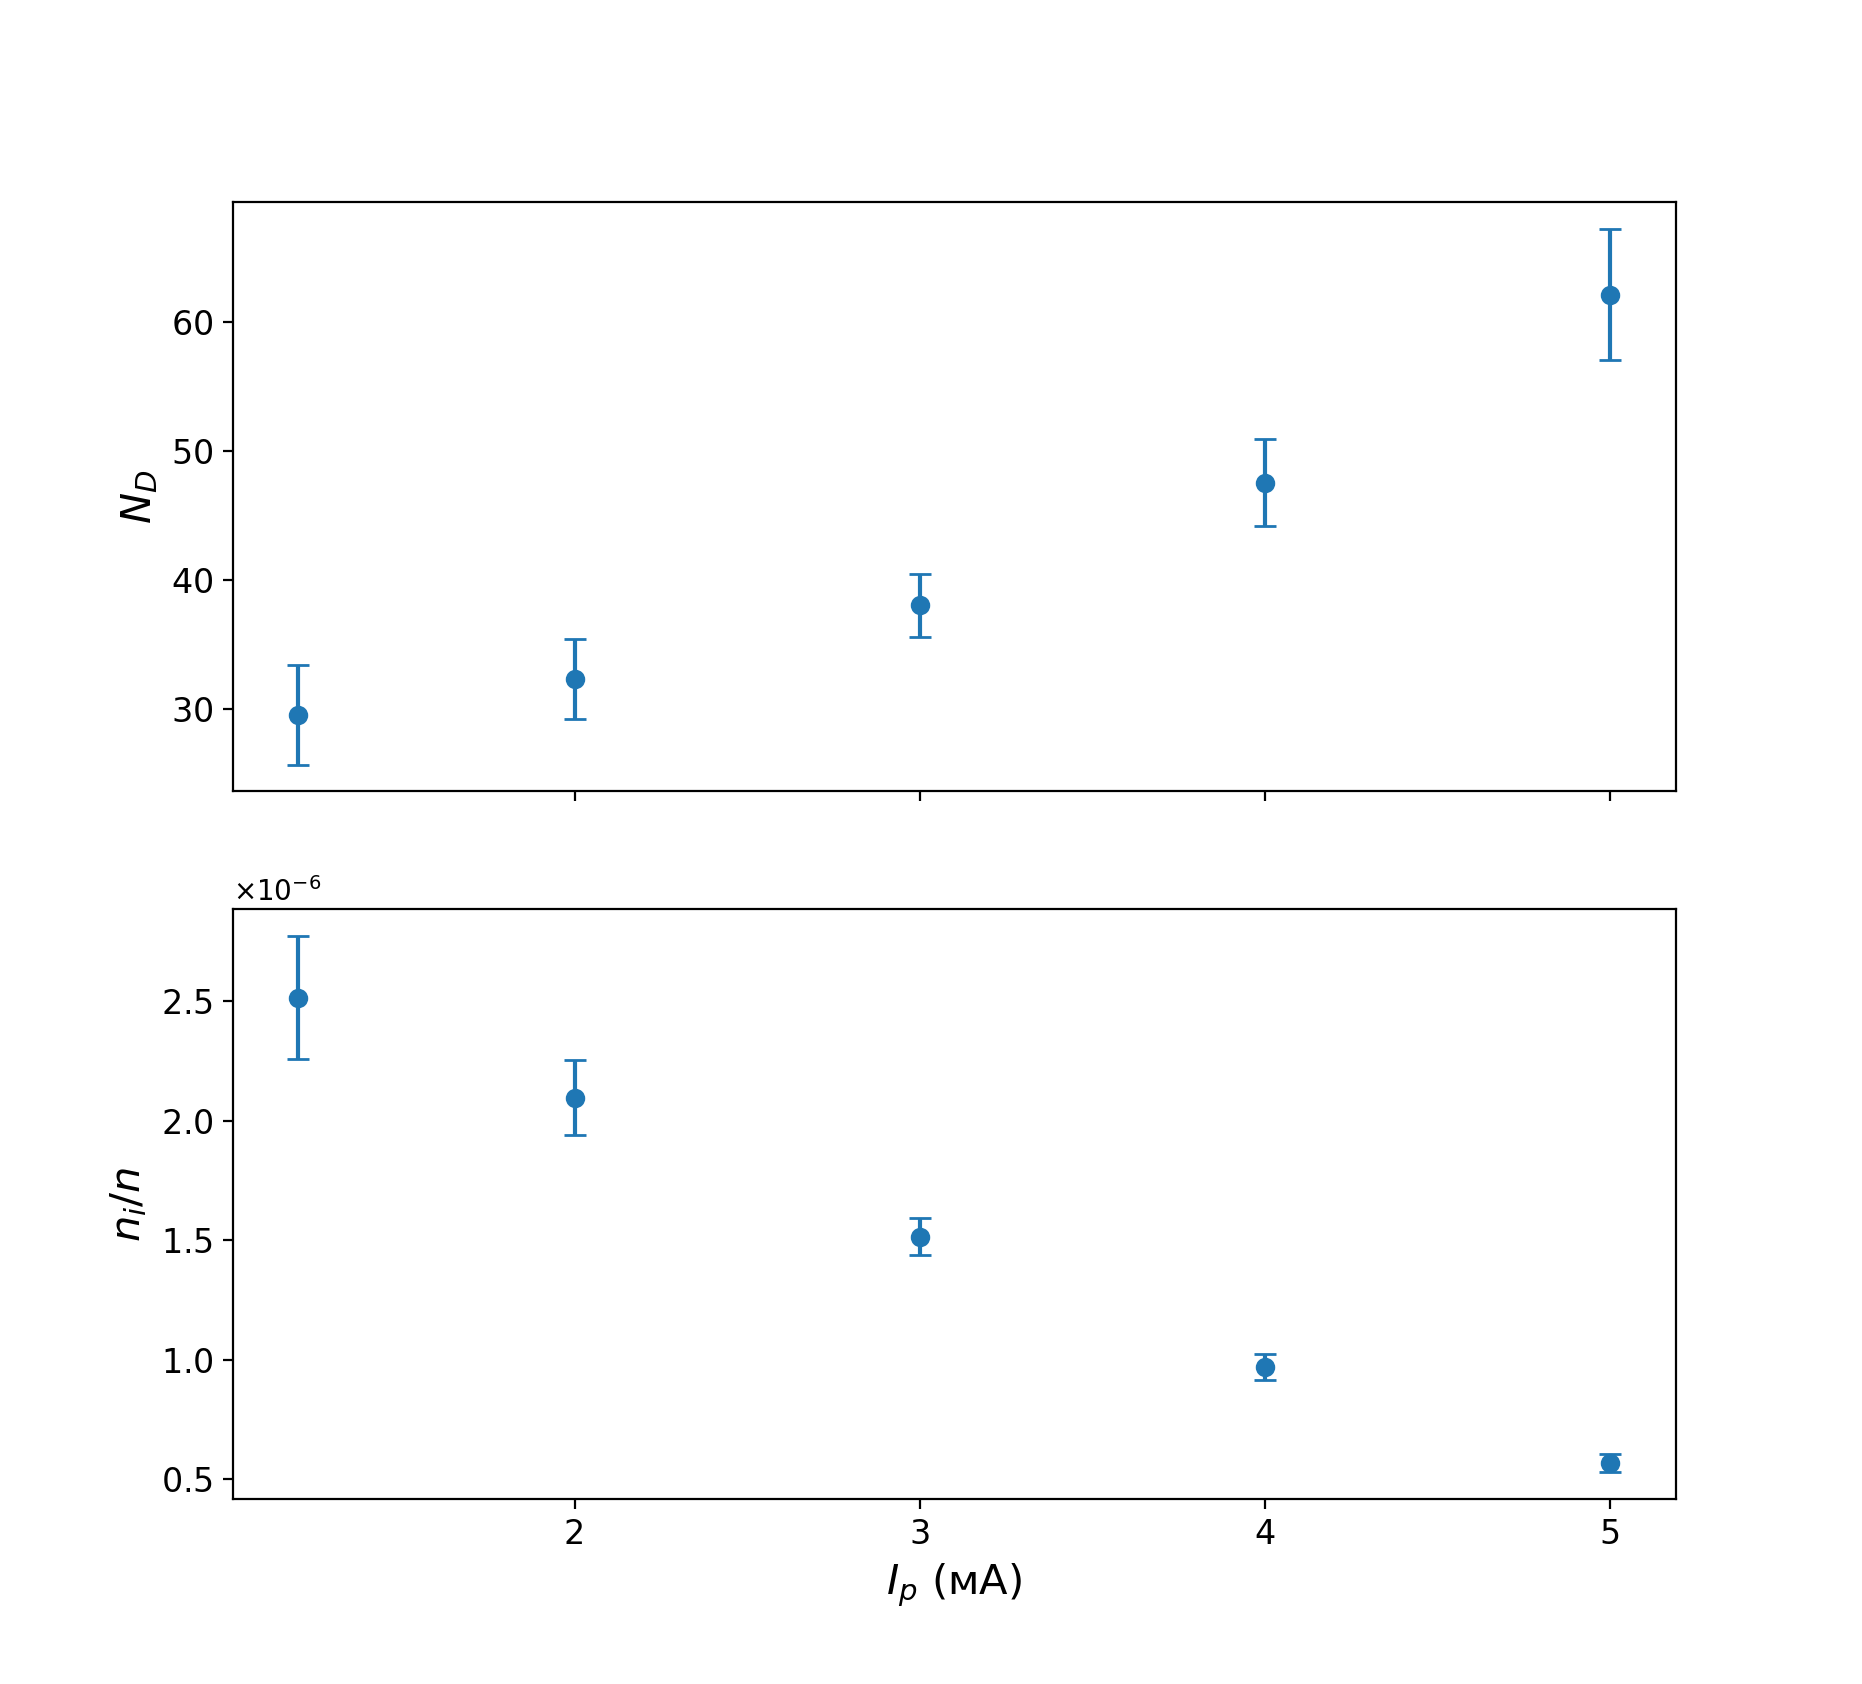

,"$I_p$, мА",$N_D$,$n_i/n$
0,1.2,29.516284,2.514762e-06
1,2.0,32.319523,2.097444e-06
2,3.0,38.021318,1.515535e-06
3,4.0,47.505115,9.708216e-07
4,5.0,62.104787,5.680284e-07


,$N_D$ (по-честному),$N_D$ (по готовой формуле)
0,29.119922,29.516284
1,31.885518,32.319523
2,37.510746,38.021318
3,46.867189,47.505115
4,61.270808,62.104787


In [7]:
if _display_normal:
    fig, axes = plt.subplots(2, 1, sharex='col', sharey='row')
else:
    #grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    axes = [plt.subplot(grid[0, 1]), plt.subplot(grid[1, 1])]

for p in axes:
    p.set_xticks(range(1, 6))
    p.tick_params(axis='both', which='major', labelsize=12)
    p.tick_params(axis='both', which='major', labelsize=12)


plt1, plt2 = axes

plt1.ticklabel_format(axis='y', style='sci', useMathText=True)
plt2.ticklabel_format(axis='y', style='sci', scilimits=(1, 10), useMathText=True)

NDeb = []
N_D = n * 4/3 * math.pi * r_D**3
NDeb.append(N_D)
N_D = 1.4e6 * (300)**(3/2) / np.sqrt(n)
NDeb.append(N_D)
eps_N = np.sqrt(eps_n**2 + 9*eps_rD**2)
sigma_N = eps_N * N_D

plt1.set_ylabel('$N_D$', fontsize=15)
plt1.errorbar(I_d, N_D, linestyle='', marker='o', yerr=sigma_N, capsize=4)

#N_L = 2.687e25  # м^-3
P = 100
alpha = k*T_i*n / P
eps_alpha = math.sqrt(2) * eps_n
sigma_alpha = eps_alpha * alpha

plt2.set_xlabel('$I_p$ (мА)', fontsize=15)
plt2.set_ylabel('$n_i / n$', fontsize=15)
plt2.errorbar(I_d, alpha, linestyle='', marker='o', yerr=sigma_alpha, capsize=4)


df = np.transpose([I_d, N_D, alpha])
display(pd.DataFrame(df, columns=['$I_p$, мА', '$N_D$', '$n_i/n$']))

display(pd.DataFrame(np.transpose(NDeb), columns=['$N_D$ (по-честному)', '$N_D$ (по готовой формуле)']))

In [ ]:
1.4e6 * ((kT * 1.6e-19 / k) ** (3/2)) / (np.sqrt(n))

In [ ]:
69 * np.sqrt((kT * 1.6e-19 / k) / n)